In [1]:
# to ignore the warning 
import warnings
warnings.filterwarnings('ignore')

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
import random 
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.resnet50 import ResNet50 
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# print(tf.config.list_physical_devices('GPU'))



In [2]:
seed_value = 42
random.seed(seed_value)  # Python
np.random.seed(seed_value)  # NumPy
tf.random.set_seed(seed_value)  # TensorFlow

In [3]:
log_dir = '../experiments/'

In [4]:
train_dir = "../data/augmented"
# test_ds = "../data/test data" # not yer made so as of right now we will be using only train and val 
val_dir = "../data/val/"

In [5]:
batch_size = 12 
img_height, img_width = 500 , 500

In [6]:
train_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [7]:
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 145 images belonging to 3 classes.


In [8]:
val_ds = train_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 29 images belonging to 3 classes.


In [10]:
train_ds.image_shape

(500, 500, 3)

In [42]:
num_classes = 3 

In [43]:
resnet= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height,img_width,3),
                   pooling='avg',
                   weights='imagenet')
for layer in resnet.layers:
        layer.trainable=False


In [44]:
# Determine 60% of the layers
num_layers_to_freeze = int(0.60* len(resnet.layers))

# Freeze the first 45% of layers
for i, layer in enumerate(resnet.layers):
    if i < num_layers_to_freeze:
        layer.trainable = False

In [45]:
model = Sequential([ resnet,
    layers.Flatten(), 
    layers.Dense(448, activation='relu'),
    layers.Dense(240, activation='relu'),
    layers.Dense(112, activation='relu'),
    layers.Dropout(0.4), 
    layers.Dense(num_classes, activation='softmax')])

In [46]:
model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 448)               917952    
                                                                 
 dense_5 (Dense)             (None, 240)               107760    
                                                                 
 dense_6 (Dense)             (None, 112)               26992     
                                                                 
 dropout_1 (Dropout)         (None, 112)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                

In [49]:
model.compile(optimizer=Adam(learning_rate=4e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"] 
             )

In [50]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10, 
  )

Epoch 1/10
13/13 [==============================] - 53s 4s/step - loss: 1.6906 - accuracy: 0.3517 - val_loss: 0.9125 - val_accuracy: 0.5862
Epoch 2/10
13/13 [==============================] - 46s 4s/step - loss: 1.0447 - accuracy: 0.4759 - val_loss: 0.9547 - val_accuracy: 0.3103
Epoch 3/10
13/13 [==============================] - 44s 3s/step - loss: 0.5420 - accuracy: 0.8207 - val_loss: 0.4637 - val_accuracy: 0.9655
Epoch 4/10
13/13 [==============================] - 44s 3s/step - loss: 0.3836 - accuracy: 0.8690 - val_loss: 0.4630 - val_accuracy: 0.7586
Epoch 5/10
13/13 [==============================] - 44s 3s/step - loss: 0.2166 - accuracy: 0.9655 - val_loss: 0.2814 - val_accuracy: 0.9655
Epoch 6/10
13/13 [==============================] - 44s 3s/step - loss: 0.1681 - accuracy: 0.9655 - val_loss: 0.1547 - val_accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 49s 4s/step - loss: 0.1008 - accuracy: 0.9862 - val_loss: 0.1761 - val_accuracy: 1.0000
Epoch 8/10
13/13 [==

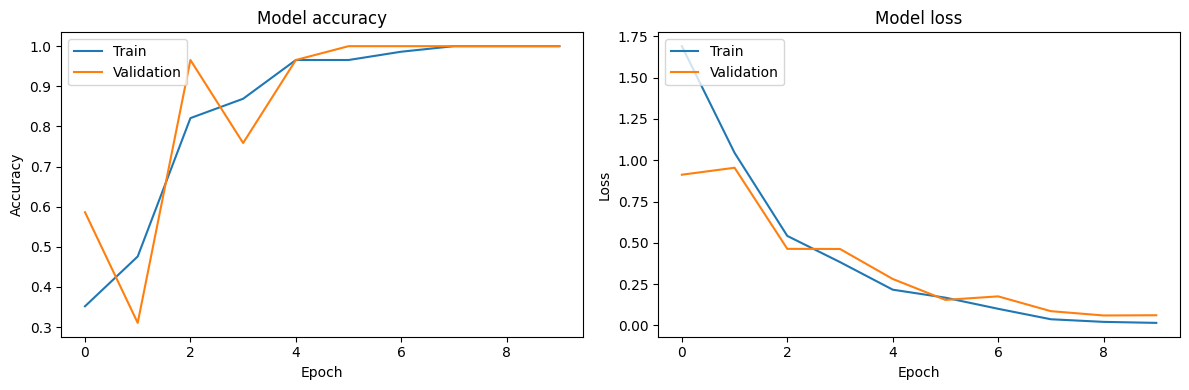

In [51]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [54]:
model.save("../models/resnet50.h5")